In [4]:
from torchvision.datasets import DatasetFolder
from torchvision.transforms import transforms as tt
from torch.utils.data import DataLoader
import torch
import os
import numpy as np
import timm_3d

In [5]:
train_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/train"
val_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/val"
test_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/test"

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [6]:
## define hyperparameters
bs = 64

In [ ]:
def pad_to_shape(volume, target_shape):
    """ Pads 3D numpy array (D,H,W) to target_shape with zeros. """
    pad_width = []
    for vol_dim, target_dim in zip(volume.shape, target_shape):
        delta = max(target_dim - vol_dim, 0)
        before = delta // 2
        after = delta - before
        pad_width.append((before, after))
    return np.pad(volume, pad_width, mode="constant", constant_values=0)

In [26]:
# 2. First pass: Determine maximum shape across train/val/test
def get_all_shapes(paths):
    shapes = []
    for p in paths:
        for root, _, files in os.walk(p):
            for f in files:
                if f.endswith(".npy"):
                    vol = np.load(os.path.join(root, f))  # (H, W, D)

                    # Convert to (D, H, W) BEFORE shape collection
                    vol = np.transpose(vol, (2, 0, 1))

                    shapes.append(vol.shape)
    return shapes

shapes = get_all_shapes([train_path, val_path, test_path])
target_shape = tuple(np.max(np.array(shapes), axis=0))


In [27]:
target_shape

(np.int64(124), np.int64(219), np.int64(191))

In [28]:
def custom_loader(path, pad:bool = True):
    vol = np.load(path)  # (H,W,D)
    vol = np.transpose(vol, (2, 0, 1)) # convert to (D, H, W)
    if pad:
        vol = pad_to_shape(vol, target_shape)
    vol = torch.tensor(vol, dtype=torch.float32)  # convert to tensor
    return vol

## Load Data + Set up model

In [12]:
import timm_3d
import torch.nn as nn

class TumourClassifier3D(nn.Module):
    def __init__(self, backbone_name='efficientnet_b1.ft_in1k', pretrained=True, num_classes=1):
        super().__init__()
        
        # Load backbone
        self.model = timm_3d.create_model(
            backbone_name,
            pretrained=pretrained,
            in_chans=1,     # single-channel (D,H,W)
            num_classes=0   # remove classification head
        )
        
        # Get output feature dimension
        if hasattr(self.model, "num_features"):
            feat_dim = self.model.num_features
        else:
            feat_dim = self.model.num_features
    
        # Add binary classifier head
        self.classifier = nn.Linear(feat_dim, num_classes)
    
    def forward(self, x):
        x = self.model(x)     # (B, feat_dim)
        x = self.classifier(x)
        return x

In [13]:
class AddChannel:
    def __call__(self, x):
        return x.unsqueeze(0)   # (1, D, H, W)

In [21]:
train_transforms = AddChannel()
test_transforms  = AddChannel()

In [29]:
# Load dataset
train_dataset = DatasetFolder(train_path, loader=custom_loader, transform=train_transforms, extensions=[".npy"])
# Access class labels
print(train_dataset.classes)
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = DatasetFolder(val_path, loader=custom_loader, transform=test_transforms, extensions=[".npy"])
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_dataset = DatasetFolder(test_path, loader=custom_loader, transform=test_transforms, extensions=[".npy"])
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

['medulloblastoma', 'plgg']


### visualize slices (sanity check)

torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) medulloblastoma
torch.Size([1, 124, 219, 191]) medulloblastoma
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) medulloblastoma
torch.Size([1, 124, 219, 191]) medulloblastoma
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg


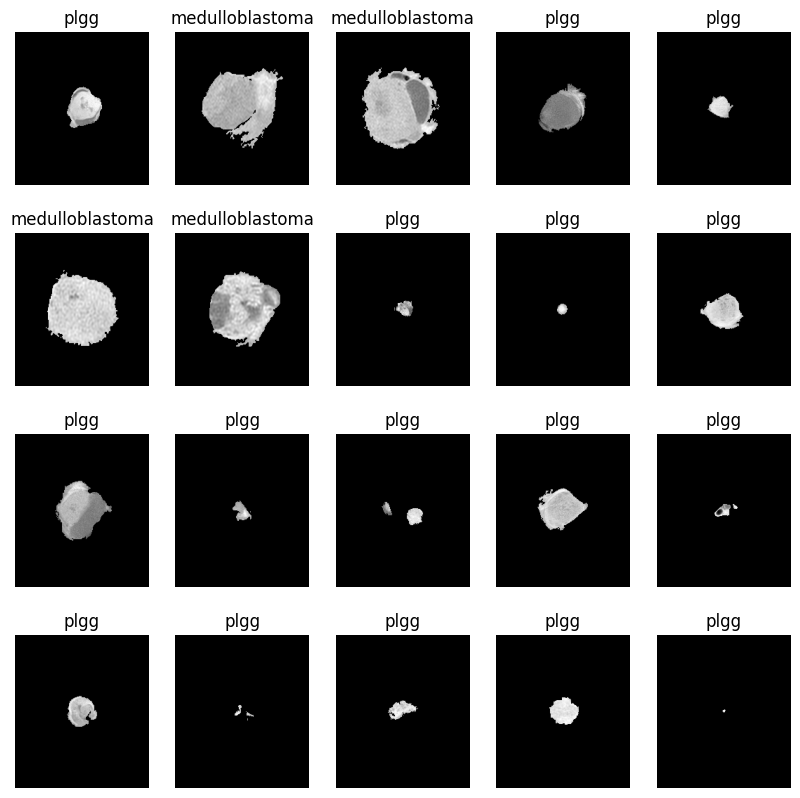

In [31]:
import matplotlib.pyplot as plt
from random import randint

# labels_map = {
#     0: "dipg",
#     1: "medulloblastoma",
#     2: "plgg"
# }

labels_map = {
    0: "medulloblastoma",
    1: "plgg"
}


# now in (1, D, W, H order)
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    tensor, label = train_dataset[sample_idx]
    print(tensor.shape, labels_map[label])
    c, d, h, w = tensor.shape
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(tensor[:,d//2,:,:].squeeze(), cmap="gray")
plt.show()

# For timm_3d the input shape must be (B, C, D, H, W).

In [36]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

class Trainer:
    def __init__(self, model, train_loader, val_loader, device=device):
        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
    
    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        
        for x, y in tqdm(self.train_loader):
            x = x.to(self.device)
            y = y.float().to(self.device)  # 0/1 labels

            preds = self.model(x).squeeze(-1)
            loss = self.criterion(preds, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for x, y in self.val_loader:
                x = x.to(self.device)
                y = y.float().to(self.device)

                preds = self.model(x).squeeze(-1)
                loss = self.criterion(preds, y)
                total_loss += loss.item()
        
        return total_loss / len(self.val_loader)
    
    def fit(self, epochs=10):
        for e in range(1, epochs + 1):
            train_loss = self.train_one_epoch()
            val_loss = self.validate()
            print(f"Epoch {e}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [37]:
def run_experiment(backbone_name, train_loader, val_loader):
    print(f"\nRunning experiment with {backbone_name} on {device}...\n")
    
    model = TumourClassifier3D(backbone_name=backbone_name, pretrained=True)
    trainer = Trainer(model, train_loader, val_loader, device=device)
    trainer.fit(epochs=1)
    
    return model

In [38]:
backbones = [
    'efficientnet_b1.ft_in1k',
]

models = {}

for b in backbones:
    models[b] = run_experiment(b, train_loader, val_loader)


Running experiment with efficientnet_b1.ft_in1k on cpu...

Convert layer weights: blocks.0.0.conv_dw.weight. Shape: torch.Size([32, 1, 3, 3]) -> torch.Size([32, 1, 3, 3, 3])
Convert layer weights: blocks.0.0.conv_pw.weight. Shape: torch.Size([16, 32, 1, 1]) -> torch.Size([16, 32, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_expand.weight. Shape: torch.Size([32, 8, 1, 1]) -> torch.Size([32, 8, 1, 1, 1])
Convert layer weights: blocks.0.0.se.conv_reduce.weight. Shape: torch.Size([8, 32, 1, 1]) -> torch.Size([8, 32, 1, 1, 1])
Convert layer weights: blocks.0.1.conv_dw.weight. Shape: torch.Size([16, 1, 3, 3]) -> torch.Size([16, 1, 3, 3, 3])
Convert layer weights: blocks.0.1.conv_pw.weight. Shape: torch.Size([16, 16, 1, 1]) -> torch.Size([16, 16, 1, 1, 1])
Convert layer weights: blocks.0.1.se.conv_expand.weight. Shape: torch.Size([16, 4, 1, 1]) -> torch.Size([16, 4, 1, 1, 1])
Convert layer weights: blocks.0.1.se.conv_reduce.weight. Shape: torch.Size([4, 16, 1, 1]) -> torch.Size([4, 16

  0%|          | 0/7 [01:33<?, ?it/s]


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16090398720 bytes.